In [ ]:
##

In [18]:
import matplotlib.pyplot as plt
import matplotlib
from surgeon_recording.reader import Reader
from glob import glob
from os.path import join
import os
import numpy as np
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from copy import deepcopy
import pandas as pd
from scipy import signal as sp
import math
import cv2
import csv
from natsort import natsorted
from surgeon_recording.synchronization import Synchro
#%matplotlib widget

from plotly import subplots

import plotly.graph_objects as go
import plotly.express as px
 

In [19]:
reader = Reader()

In [20]:
#data_folder = join('..', 'data_exp')

subject_list = ['1','2','3','4','5','6','7','8','9','10','11','12']
#subject_list = ['3']
segment_list = ['500','510','530','540','541','560']
#segment_list = ['560']

blacklist = []
#blacklist = ['1/run2', '3/run3', '3/run5']
#blacklist = ['7/run2']
#blacklist = [join(data_folder, x) for x in blacklist]

#specialty_keys = ["neuro", "plastic", "general", "none", "maxilo"]
expertise_keys = ["novice", "expert"]

sensors = ['optitrack', 'emg', 'TPS_calibrated']


tools_tweezer = ['tweezer_x', 'tweezer_y', 'tweezer_z']
tools_scissors = ['scissors_x', 'scissors_y', 'scissors_z'] 
#tools_verif_holder = ['needle_holder_x', 'needle_holder_y', 'needle_holder_z'] #subject 1
tools_verif_holder = ['needle_holder2_x', 'needle_holder2_y', 'needle_holder2_z'] #subject 2 to 12

path_to_data_folder = '/home/anaelle/git/surgeon_recording/data_exp'                 #lasa computer


In [101]:
data_segments = {}
mean_segments = {}
emg_segment_subject={}
tps_segment_subject={}
abs_diff_tps = {}
range_raw_tps_subject = {}

recording_session = {}
run_list = {}
run_list_emg = {}

headers = {}
file_list = {}


run_list_emg['1'] = ['1','2', '3','4','5']
run_list_emg['2'] = ['1','3','4','6','7']
run_list_emg['3'] = ['2','3','6', '7']
run_list_emg['4'] = ['1','3','4','5','6']
run_list_emg['5'] = ['3', '5']
run_list_emg['6'] = ['1','5']
run_list_emg['7'] = ['1','3','4','6','7']
run_list_emg['8'] = ['3','4', '6']
run_list_emg['9'] = ['2','3','5', '7']
run_list_emg['10'] = ['1','2','4','5','6']
run_list_emg['11'] = ['3','4', '5']
run_list_emg['12'] = ['1','2','3']

run_list['1'] = ['1','2', '3','4','5']
run_list['2'] = ['1','3','4','6','7']
run_list['3'] = ['2','3','4','6', '7']
run_list['4'] = ['1','3','4','5','6']
run_list['5'] = ['3', '5']
run_list['6'] = ['1','3','5']
run_list['7'] = ['1','3','4','6','7']
run_list['8'] = ['1','2','3','4', '6']
run_list['9'] = ['2','3','5', '7']
run_list['10'] = ['1','2','4','5','6']
run_list['11'] = ['1','3','4','5']
run_list['12'] = ['1','2','3']


recording_session['1'] = '70622'
recording_session['2'] = '70622'
recording_session['3'] = '80622'
recording_session['4'] = '80622'
recording_session['5'] = '80622'
recording_session['6'] = '90622'
recording_session['7'] = '90622'
recording_session['8'] = '90622'
recording_session['9'] = '90622'
recording_session['10']= '100622'
recording_session['11']= '100622'
recording_session['12']= '100622'



for subject in subject_list:
    data_segments[subject] = {}
    mean_segments[subject]= {}
    file_list[subject] = {}
    emg_segment_subject[subject] = {}
    tps_segment_subject[subject] = {}
    
    abs_diff_tps[subject] = {}
    range_raw_tps_subject[subject] = {}
                     
    
        
    for run in run_list[subject]:
        data_segments[subject][run] = {}
        mean_segments[subject][run]= {}
        file_list[subject][run] = {}
        abs_diff_tps[subject][run] = {}
        
        
        for sensor in sensors:
            data_segments[subject][run][sensor]= {}
            mean_segments[subject][run][sensor]= {}
            file_list[subject][run][sensor] = {}

            for segment in segment_list:
                data_segments[subject][run][sensor][segment]= {}
                file_list[subject][run][sensor][segment] = []
                mean_segments[subject][run][sensor][segment]= {}
                
                emg_segment_subject[subject][segment]={}
                tps_segment_subject[subject][segment]={}
                abs_diff_tps[subject][run][segment] = {}
                range_raw_tps_subject[subject][segment] = {}

                

for sensor in sensors:
    headers[sensor] = []
                
            

In [103]:
for subject in subject_list:   
    
    
    for run in run_list[subject]:
    
        data_folder = join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION' )
        
        for sensor in ['optitrack', 'TPS_calibrated']:
            
            for segment in segment_list:
                file_list[subject][run][sensor][segment] = join(data_folder, 'segment_nb_' + segment + '_' + sensor +'.csv')
                
                file = open(file_list[subject][run][sensor][segment])
                reader = csv.DictReader(file)
                headers[sensor] = reader.fieldnames
                
                
                if sensor == 'optitrack':
                    tools = headers[sensor][3:-1]
                if sensor == 'TPS_calibrated':
                    fingers_cal = headers[sensor][15:-1]

                    
                data = pd.read_csv(file_list[subject][run][sensor][segment])
                
        
                if sensor == 'TPS_calibrated':
                    for finger in fingers_cal:                    
                        data_segments[subject][run][sensor][segment][finger]= data[finger]
                        data_segments[subject][run][sensor][segment]['rel_time'] = data[' relative_time']
                    
                if sensor == 'optitrack':
                    for tool in tools:
                        data_segments[subject][run][sensor][segment][tool]= data[tool]
                        data_segments[subject][run][sensor][segment]['rel_time'] = data['relative_time']              
                    
                    
for subject in subject_list:   
    for run in run_list_emg[subject]:

        data_folder = join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION' )

        for sensor in ['emg']:

            for segment in segment_list:
                file_list[subject][run][sensor][segment] = join(data_folder, 'segment_nb_' + segment + '_' + sensor +'.csv')

                file = open(file_list[subject][run][sensor][segment])
                reader = csv.DictReader(file)
                headers[sensor] = reader.fieldnames


                if sensor == 'emg':
                    channels = headers['emg'][4:]

                data = pd.read_csv(file_list[subject][run][sensor][segment])


                if sensor == 'emg':
                    for channel in channels:                    
                        data_segments[subject][run][sensor][segment][channel]= data[channel]
                        data_segments[subject][run][sensor][segment]['rel_time'] = data['relative_time']

                                
                
                

## EMG processing

In [23]:

fs = 1000
fny = fs/2
fco = 25
rms_window = 20

sensor = 'emg'

for subject in subject_list:   
        for segment in segment_list:
            for channel in channels:  
                emg_segment_subject[subject][segment][channel]=[]




for subject in subject_list:   
    for run in run_list_emg[subject]:
        for segment in segment_list:
            
            for channel in channels:  
                
            #channel = 'emg0'
                data_current = np.array(data_segments[subject][run][sensor][segment][channel])
                # Remove all occurrences of elements with value above 1000 (outliers)
                data_current = data_current[data_current < 1000]
                data_current = data_current[data_current > -1000]
                # remove missing data points
                data_current = data_current[data_current != 0]  

                #data_analysis.processed_emg_data
                N = 4
                plt.ion
                [b, a] = sp.butter(N, 1.16*fco/fny)
                rec_signal = abs(data_current)
                butt_signal = sp.filtfilt(b, a, rec_signal)

                rms_env = np.sqrt(np.convolve(np.square(rec_signal), np.ones(rms_window)/rms_window, mode='same'))

                start_zoom = 1
                stop_zoom = 1000
                df = pd.DataFrame({

                    'rectified signal':rec_signal[start_zoom:stop_zoom],
                    'Butterworth':butt_signal[start_zoom:stop_zoom],
                    'RMS':rms_env[start_zoom:stop_zoom]
                })
                #fig = px.line([rec_signal, butt_signal])
                fig = px.line(df)

                # showing the plot
                #fig.show()

                if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'emg_plots' )):
                    os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'emg_plots'))
                fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION','emg_plots', 'segment' + segment + '_' + channel +'_zoom.png'))


                df = pd.DataFrame({

                    'line2':rec_signal,
                    'line1':butt_signal,
                    'line3':rms_env
                })
                #fig = px.line([rec_signal, butt_signal])
                fig = px.line(df)

                # showing the plot
                #fig.show()
                fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION','emg_plots', 'segment' + segment + '_' + channel +'_tot.png'))
                
                
                mean_segments[subject][run][sensor][segment][channel] = np.mean(butt_signal) #valeurs moyennes pour un subject sur ce run pour chaque channel
                 
                emg_segment_subject[subject][segment][channel].append(butt_signal) #valeurs emg pour 1 sujet, plusieurs runs, 1 channel

            

### plot emg means on colormap per run per subject AND per subject for all runs

In [24]:
sensor = 'emg'
for subject in subject_list:   
    for segment in segment_list:
        
            fig = go.Figure()
            x_values = []
            y_values_tot = []
            y_min = 0
            y_max = 50
            y_limit = 1.5

        
            for i, channel in enumerate(channels):
                x_values.append(i)
                
                tot_signal = np.concatenate(emg_segment_subject[subject][segment][channel])
                y_values_tot.append(np.mean(tot_signal))
            
            y_values_tot = (np.array(y_values_tot) - y_min) / (y_max - y_min)

            fig.add_trace(go.Scatter(
                x=x_values,
                y=y_values_tot,
                marker=dict(
                    size=16,
                    cmax=1,
                    cmin=0,
                    color=y_values_tot,
                    colorbar=dict(
                        title='Colorbar, 1=' + str(y_max) +' [uV]'
                    ),
                    colorscale="rainbow"
                    
                ),
                mode="markers"))
            
            fig.update_layout(title='Mean value of EMG enveloppes over runs, one subject',
                   xaxis_title='EMG channels',
                   yaxis_title='EMG data',
                   width=1025,
                   height=500,
                   yaxis_range=[0,y_limit])
            
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS')):
                    os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS'))

            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, 'PLOTS', 'colormap_subject'+ subject + '_segment' + segment + '_' +'.png'))
            
            for run in run_list_emg[subject]:
                fig = go.Figure()
                x_values = []
                y_values = []

                for i, channel in enumerate(channels):
                    x_values.append(i)
                    y_values.append(mean_segments[subject][run][sensor][segment][channel])

                y_values = (np.array(y_values) - y_min) / (y_max - y_min)

                fig.add_trace(go.Scatter(
                    x=x_values,
                    y=y_values,
                    marker=dict(
                        size=16,
                        cmax=1,
                        cmin=0,
                        color=y_values,
                        colorbar=dict(
                            title='Colorbar, 1=' + str(y_max) +' [uV]'
                        ),
                        colorscale="rainbow"
                    ),
                    mode="markers"))
                
                fig.update_layout(title='Mean value of EMG enveloppes, one run',
                   xaxis_title='EMG channels',
                   yaxis_title='EMG data',
                   width=1025,
                   height=500,
                   yaxis_range=[0,y_limit])

                if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'PLOTS')):
                        os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'PLOTS'))

                fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'PLOTS', 'colormap_subject'+ 'subject' + '_segment' + segment + '_run' + run +'.png'))
            

### colormap per expertise


In [25]:
sensor = 'emg'
expert_subjects = ['4','10','3']
novice_subjects = ['7', '12','9']
category = ['novice', 'expert']

y_min = 0
y_max = 50
y_limit=2

subject_expertise = {
    'expert': expert_subjects,
    'novice': novice_subjects
}
emg_segment_subject_expertise = {}
for cat in category: 
    emg_segment_subject_expertise[cat] = {}
    for segment in segment_list:
        emg_segment_subject_expertise[cat][segment] = {}
        for channel in channels:
            emg_segment_subject_expertise[cat][segment][channel] = []
    
    
for cat in category:               
    for subject in subject_expertise[cat]:   
        for segment in segment_list:
                for channel in channels:
                    emg_segment_subject_expertise[cat][segment][channel].append(emg_segment_subject[subject][segment][channel]) #met a la suite les valeurs de donnes pour les runs des sujets avec la meme expertise, pour 1 channel

for cat in category:               
    for subject in subject_expertise[cat]:   
        for segment in segment_list:
                fig = go.Figure(layout_yaxis_range=[0,1])
                x_values = []
                y_values_tot = []
                
                
                
                for i, channel in enumerate(channels):
                    x_values.append(i)

                    tot_signal = np.concatenate(np.concatenate(emg_segment_subject_expertise[cat][segment][channel]))
                    y_values_tot.append(np.mean(tot_signal))

                y_values_tot = (np.array(y_values_tot) - y_min) / (y_max - y_min)

                fig.add_trace(go.Scatter(
                    x=x_values,
                    y=y_values_tot,
                    marker=dict(
                        size=16,
                        cmax=1,
                        cmin=0,
                        color=y_values_tot,
                        colorbar=dict(
                            title='Colorbar, 1=' + str(y_max) +' [uV]'
                        ),
                        colorscale="rainbow",
                        
                    ),
                    mode="markers"),
                    )
                fig.update_layout(title='Mean value of EMG enveloppes for' + cat + ' subjects',
                   xaxis_title='EMG channels',
                   yaxis_title='EMG data',
                   width=1025,
                   height=500,
                   yaxis_range=[0,y_limit])


                if not os.path.exists(join(path_to_data_folder, 'plots_expertise' )):
                        os.makedirs(join(path_to_data_folder,'plots_expertise'))

                fig.write_image(join('..', 'data_exp', 'plots_expertise', 'colormap_segment' + segment + '_' + cat +'.png'))
                


## TPS processing

In [26]:
sensor = 'TPS_calibrated'

for subject in subject_list:   
        for segment in segment_list:
            for finger in fingers_cal:  
                tps_segment_subject[subject][segment][finger]=[]
                range_raw_tps_subject[subject][segment][finger] = []

                for run in run_list[subject]:
                    abs_diff_tps[subject][run][segment][finger] = []




for subject in subject_list:   
    for run in run_list[subject]:
        for segment in segment_list:
            time_current =  np.array(data_segments[subject][run][sensor][segment]['rel_time']/1000) #CONVERSION EN SECONDES
            
            for finger in fingers_cal:  
                
                data_current = np.array(data_segments[subject][run][sensor][segment][finger])
                #Newton diff method
                diff_tps = (data_current[1:-1] - data_current[0:-2])/(time_current[1:-1] - time_current[0:-2])
                #take abs value of derivative to take into account press and releas variations
                abs_diff_tps[subject][run][segment][finger] = abs(diff_tps)
                # compute range value to have measurement of how much force is applied
                range_raw_tps = max(data_current) - min(data_current)
                
                tps_segment_subject[subject][segment][finger].append(abs(diff_tps)) #valeurs abs derivative tps a la suite pour les runs de 1 sujet, 1 finger
                range_raw_tps_subject[subject][segment][finger].append(range_raw_tps) #valeurs des range a la suite pour les runs de 1 sujet pour 1 finger
                

            df = pd.DataFrame({
                fingers_cal[0]: data_segments[subject][run][sensor][segment][fingers_cal[0]][1:-1],
                fingers_cal[1]: data_segments[subject][run][sensor][segment][fingers_cal[1]][1:-1],
                fingers_cal[2]: data_segments[subject][run][sensor][segment][fingers_cal[2]][1:-1],
                fingers_cal[3]: data_segments[subject][run][sensor][segment][fingers_cal[3]][1:-1],
                fingers_cal[4]: data_segments[subject][run][sensor][segment][fingers_cal[4]][1:-1],
                fingers_cal[5]: data_segments[subject][run][sensor][segment][fingers_cal[5]][1:-1],
                'Derivation, abs value, left index':abs_diff_tps[subject][run][segment][fingers_cal[0]],
                'Derivation, abs value, left middle':abs_diff_tps[subject][run][segment][fingers_cal[1]],
                'Derivation, abs value, left thumb':abs_diff_tps[subject][run][segment][fingers_cal[2]],
                'Derivation, abs value, right index':abs_diff_tps[subject][run][segment][fingers_cal[3]],
                'Derivation, abs value, right middle':abs_diff_tps[subject][run][segment][fingers_cal[4]],
                'Derivation, abs value, right thumb':abs_diff_tps[subject][run][segment][fingers_cal[5]]
            })
            
            fig = go.Figure()
            fig.add_trace(go.Scatter(y=df[fingers_cal[0]], x=time_current-time_current[0],
                    mode='lines', name=fingers_cal[0]))
            fig.add_trace(go.Scatter(y=df[fingers_cal[1]], x=time_current-time_current[0],
                    mode='lines', name=fingers_cal[1]))
            fig.add_trace(go.Scatter(y=df[fingers_cal[2]], x=time_current-time_current[0],
                    mode='lines', name=fingers_cal[2]))

            fig.add_trace(go.Scatter(y=df[fingers_cal[3]], x=time_current-time_current[0],
                    mode='lines', name=fingers_cal[3]))
            fig.add_trace(go.Scatter(y=df[fingers_cal[4]], x=time_current-time_current[0],
                    mode='lines', name=fingers_cal[4]))
            fig.add_trace(go.Scatter(y=df[fingers_cal[5]], x=time_current-time_current[0],
                    mode='lines', name=fingers_cal[5]))
            #fig.show()
            
    

            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'tps_plots' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'tps_plots'))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION','tps_plots', 'segment' + segment  +'_raw_cal.png'))
    
            fig = go.Figure()
            fig.add_trace(go.Scatter(y=df['Derivation, abs value, left index'], x=time_current-time_current[0],
                    mode='lines', name='Derivation, abs value, left index'))
            fig.add_trace(go.Scatter(y=df['Derivation, abs value, left middle'], x=time_current-time_current[0],
                    mode='lines', name='Derivation, abs value, left middle'))
            fig.add_trace(go.Scatter(y=df['Derivation, abs value, left thumb'], x=time_current-time_current[0],
                    mode='lines', name='Derivation, abs value, left thumb'))

            fig.add_trace(go.Scatter(y=df['Derivation, abs value, right index'], x=time_current-time_current[0],
                    mode='lines', name='Derivation, abs value, right index'))
            fig.add_trace(go.Scatter(y=df['Derivation, abs value, right middle'], x=time_current-time_current[0],
                    mode='lines', name='Derivation, abs value, right middle'))
            fig.add_trace(go.Scatter(y=df['Derivation, abs value, right thumb'], x=time_current-time_current[0],
                    mode='lines', name='Derivation, abs value, right thumb'))
            #fig.show()
            
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION','tps_plots', 'segment' + segment +'_abs_derivative.png'))

            

### plot tps colormap for each run and for every run of 1 subject

In [27]:
sensor = 'TPS_calibrated'
for subject in subject_list:   
    for segment in segment_list:
        
            fig = go.Figure()
            x_values = []
            y_values_tot = []
            y_min = 0
            y_limit_diff = 5
            y_limit_range =5
            y_max_range = 2
            y_max_diff = 0.5

        
            for i, finger in enumerate(fingers_cal):
                x_values.append(i)
                
                tot_signal = np.concatenate(tps_segment_subject[subject][segment][finger]) #tous les runs pour un subject, valeur abs de la derivee
                y_values_tot.append(np.mean(tot_signal)) #valeur moyenne pour un sujet
            
            y_values_tot = (np.array(y_values_tot) - y_min) / (y_max_diff - y_min)

            fig.add_trace(go.Scatter(
                x=x_values,
                y=y_values_tot,
                marker=dict(
                    size=16,
                    cmax=1,
                    cmin=0,
                    color=y_values_tot,
                    colorbar=dict(
                        title='Colorbar, 1=' + str(y_max_diff) + '[lbs/s]'
                    ),
                    colorscale="rainbow"
                ),
                mode="markers"))
            
            fig.update_layout(title='Mean abs value of derivative, one subject',
                   xaxis_title='left_index,  left_middle,  left_thumb, right_index, right_middle, right_thumb',
                   yaxis_title='TPS data',
                   yaxis_range=[0,y_limit_diff])
            
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS')):
                    os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS'))

            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, 'PLOTS', 'TPS_diff_colormap_subject' +subject + '_segment' + segment + '_' +'.png'))
            
          
            fig = go.Figure()
            x_values = []
            y_values_tot = []

            for i, finger in enumerate(fingers_cal):
                x_values.append(i)
                y_values_tot.append(np.mean(range_raw_tps_subject[subject][segment][finger])) #ajoute a y les valeurs moyennes des range des run pour chaque doigt

            y_values_tot = (np.array(y_values_tot) - y_min) / (y_max_range - y_min)

            fig.add_trace(go.Scatter(
                x=x_values,
                y=y_values_tot,
                marker=dict(
                    size=16,
                    cmax=1,
                    cmin=0,
                    color=y_values_tot,
                    colorbar=dict(
                        title='Colorbar, 1=' + str(y_max_range) + '[lbs]'
                    ),
                    colorscale="rainbow"
                ),
                mode="markers"))
            
            fig.update_layout(title='Mean value of ranges, one subject',
                   xaxis_title='left_index,  left_middle,  left_thumb, right_index, right_middle, right_thumb',
                   yaxis_title='TPS data',
                   yaxis_range=[0,y_limit_range])

            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, 'PLOTS', 'TPS_range_colormap_subject' +subject + '_segment' + segment + '_' +'.png'))


     

      
                
            #figures for each run separately
            for j, run in enumerate(run_list[subject]):
                fig = go.Figure()
                x_values = []
                y_values = []      
            
                
                for i, finger in enumerate(fingers_cal):
                    x_values.append(i)

                    mean_signal = np.mean(tps_segment_subject[subject][segment][finger][j]) #moyenne pour 1 run pour un subject, valeur abs de la derivee
                    y_values.append(mean_signal)

                y_values = (np.array(y_values) - y_min) / (y_max_diff - y_min)
                
                

                fig.add_trace(go.Scatter(
                    x=x_values,
                    y=y_values,
                    marker=dict(
                        size=16,
                        cmax=1,
                        cmin=0,
                        color=y_values,
                        colorbar=dict(
                            title='Colorbar, 1=' + str(y_max_diff) + '[lbs/s]'
                        ),
                        colorscale="rdylgn_r"
                    ),
                    mode="markers"))
                
                fig.update_layout(title='Mean abs value of derivative, one run',
                   xaxis_title='left_index,  left_middle,  left_thumb, right_index, right_middle, right_thumb',
                   yaxis_title='TPS data',
                   yaxis_range=[0,y_limit_diff])


                if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'PLOTS')):
                            os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'PLOTS'))

                fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'PLOTS', 'TPS_diff_colormapsubject' +subject + '_segment' + segment + 'run_' + run +'.png'))

                
            for j, run in enumerate(run_list[subject]):
                fig = go.Figure()
                x_values = []
                y_values = []

                for i, finger in enumerate(fingers_cal):
                    x_values.append(i)
                    y_values.append(np.array(range_raw_tps_subject[subject][segment][finger][j]))
                    
                y_values = (np.array(y_values) - y_min) / (y_max_range - y_min)

                fig.add_trace(go.Scatter(
                    x=x_values,
                    y=y_values,
                    marker=dict(
                        size=16,
                        cmax=1,
                        cmin=0,
                        color=y_values,
                        colorbar=dict(
                            title='Colorbar, 1=' + str(y_max_range) + '[lbs]'
                        ),
                        colorscale="rdylgn_r"
                    ),
                    mode="markers"))
                
                fig.update_layout(title='Values of ranges, one run',
                   xaxis_title='left_index,  left_middle,  left_thumb, right_index, right_middle, right_thumb',
                   yaxis_title='TPS data',
                   yaxis_range=[0,y_limit_range])


                fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'PLOTS', 'TPS_range_colormapsubject' +subject + '_segment' + segment + 'run_' + run +'.png'))


                 

# take time data 

## time data  for entire run (560)

In [28]:
duration_run = {}
mean_duration_run ={}

for subject in subject_list:
    duration_run[subject] = []
    for run in run_list[subject]:                      
        duration_run[subject].append(np.array(data_segments[subject][run]['optitrack']['560']['rel_time'])[-1] - np.array(data_segments[subject][run]['optitrack'][segment]['rel_time'])[0] )
        #based on optitrack relative time of segment 560 
        
    mean_duration_run[subject] = np.mean(duration_run[subject])
    print('subject nb ' + str(subject) + '      mean duration of entire procedure over runs = ' + str(mean_duration_run[subject]))

subject nb 1      mean duration of entire procedure over runs = 102.13999999999942
subject nb 2      mean duration of entire procedure over runs = 163.5716666666649
subject nb 3      mean duration of entire procedure over runs = 64.67083333333335
subject nb 4      mean duration of entire procedure over runs = 83.17666666666555
subject nb 5      mean duration of entire procedure over runs = 187.24999999999818
subject nb 6      mean duration of entire procedure over runs = 207.4333333333334
subject nb 7      mean duration of entire procedure over runs = 198.22999999999337
subject nb 8      mean duration of entire procedure over runs = 102.4055555555545
subject nb 9      mean duration of entire procedure over runs = 363.87291666666533
subject nb 10      mean duration of entire procedure over runs = 51.03166666666666
subject nb 11      mean duration of entire procedure over runs = 81.49444444444482
subject nb 12      mean duration of entire procedure over runs = 220.7361111111113


## time data for each segment

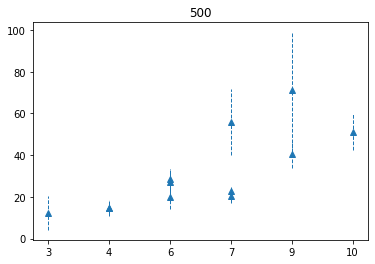

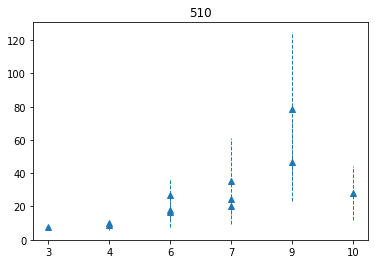

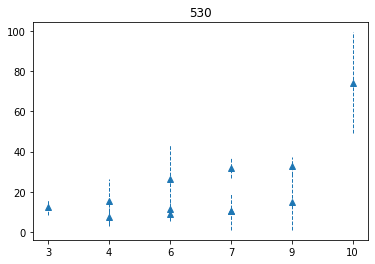

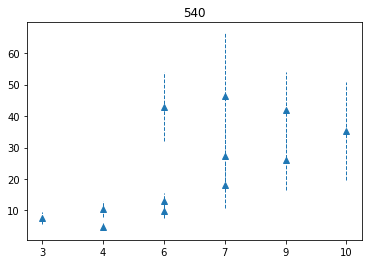

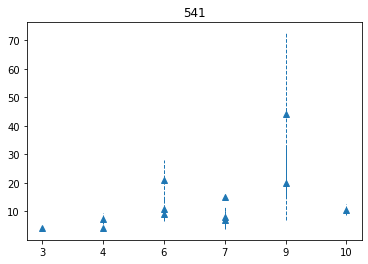

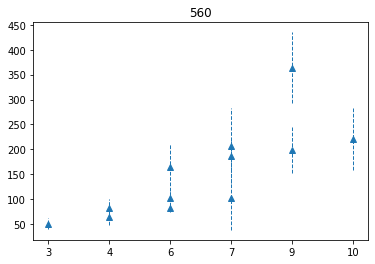

In [29]:
duration_run_segments = {}
mean_duration_run_segments ={}
std_duration_run_segments ={}

for subject in subject_list:
    duration_run_segments[subject] = {} 
    mean_duration_run_segments[subject] = {} 
    std_duration_run_segments[subject] = {}  
    for segment in segment_list:
        duration_run_segments[subject][segment] = [] 
        mean_duration_run_segments[subject][segment] = []
        std_duration_run_segments[subject][segment] = []
        
        
for subject in subject_list:
    for segment in segment_list:
        for run in run_list[subject]: 
            duration_run_segments[subject][segment].append(np.array(data_segments[subject][run]['optitrack'][segment]['rel_time'])[-1] - np.array(data_segments[subject][run]['optitrack'][segment]['rel_time'])[0] )
            #based on optitrack relative time of segment 560 
        
        mean_duration_run_segments[subject][segment] = np.mean(duration_run_segments[subject][segment])
        std_duration_run_segments[subject][segment] = np.std(duration_run_segments[subject][segment])


subject_order = ['10','3','4','11','8','2','1','5','6','7','12','9']
ALI_score = ['3','4','4','6','6','6','7','7','7','9','10','9']
#subject_order = ['10','3','4','8','2','1','5','6','7','12']
#ALI_score = ['3','4','4','6','6','7','7','7','9','10']


for segment in segment_list:
    eb1 = []
    x = []
    y = []
    e = []
    for subject in subject_order:
        
        y.append(mean_duration_run_segments[subject][segment])
        e.append(std_duration_run_segments[subject][segment])
    x= ALI_score
    eb1 = plt.errorbar(x, y, e,lw=1, linestyle = 'None', marker='^')
    eb1[-1][0].set_linestyle('--') 
    plt.title(str(segment), fontdict=None, loc='center', pad=None)
    # To show the plot
    
    
    if not os.path.exists(join(path_to_data_folder , 'PLOTS', 'TIME')):
             os.makedirs(join(path_to_data_folder , 'PLOTS', 'TIME'))

    plt.savefig(join('..', 'data_exp' , 'PLOTS', 'TIME', 'time_segment' + segment  +'.png'))
    plt.show()


# PLOTS HAND POSTURE

In [30]:
#plot tps activity = sum derivative active fingers

from plotly.subplots import make_subplots
import plotly.graph_objects as go

RH_fingers = {
    '10':[fingers_cal[5],fingers_cal[3] ], #thumb, index
    '9':[fingers_cal[5],fingers_cal[3] ],
    '3':[fingers_cal[5]],
    '4':[fingers_cal[5]],
    '5':[fingers_cal[5]],
    '6':[fingers_cal[5],fingers_cal[3]],
    '7':[fingers_cal[5],fingers_cal[3] ]

    
    }

LH_fingers = {
    '10':[fingers_cal[2],fingers_cal[0],fingers_cal[1] ], #thumb, index, middle
    '9':[fingers_cal[2],fingers_cal[0],fingers_cal[1] ],
    '3':[fingers_cal[2],fingers_cal[0],fingers_cal[1] ],
    '6':[fingers_cal[2],fingers_cal[0],fingers_cal[1] ],
    '5':[fingers_cal[2],fingers_cal[1] ],
    '4':[fingers_cal[2],fingers_cal[0] ],
    '7':[fingers_cal[2],fingers_cal[0],fingers_cal[1] ] 
    }


sensor = 'TPS_calibrated'

subject_list_tps_activity = ['10','9','3','7','6','5','4']
segment_list_tps_activity =['560','540','500']

sum_derivative_RH = {}
sum_derivative_LH = {}

for subject in subject_list_tps_activity:   
    sum_derivative_RH[subject]={}
    sum_derivative_LH[subject]={}
    for run in run_list[subject]:
        sum_derivative_RH[subject][run]={}
        sum_derivative_LH[subject][run]={}
        for segment in segment_list_tps_activity:
            sum_derivative_RH[subject][run][segment] = []
            sum_derivative_LH[subject][run][segment] = []
                


for subject in subject_list_tps_activity:   
    for run in run_list[subject]:
        for segment in segment_list_tps_activity:
            time_current =  np.array(data_segments[subject][run][sensor][segment]['rel_time']/1000) #CONVERSION EN SECONDES
            
            sum_derivative_RH[subject][run][segment] = np.zeros(len(time_current)-2)
            sum_derivative_LH[subject][run][segment] = np.zeros(len(time_current)-2)
            for finger in RH_fingers[subject]:
                sum_derivative_RH[subject][run][segment] = sum_derivative_RH[subject][run][segment] + (abs_diff_tps[subject][run][segment][finger])
                
            for finger in LH_fingers[subject]:
                sum_derivative_LH[subject][run][segment] = sum_derivative_LH[subject][run][segment] + (abs_diff_tps[subject][run][segment][finger])
                
                
                    
                
                

            df = pd.DataFrame({
                'Activity right hand':sum_derivative_RH[subject][run][segment]/max(sum_derivative_RH[subject][run][segment]),
                'Activity left hand':sum_derivative_LH[subject][run][segment]/max(sum_derivative_LH[subject][run][segment]),
                
            })
            


            fig  = go.Figure()
            fig = make_subplots(rows=2, cols=1) 
            
            fig.add_trace(go.Scatter(y=df['Activity right hand'], x=time_current-time_current[0],
                    mode='lines', name='Right hand'),1,1)

            
            fig.add_trace(go.Scatter(y=df['Activity left hand'], x=time_current-time_current[0],
                    mode='lines', name='Left hand'),2,1)
            
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                   xaxis_title='Time',
                   yaxis_title='TPS derivative',
                   width=1025,
                   height=500,
                             )
            
            fig.update_yaxes(range=[0, 0.5])


            #fig.show()
            
    

            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'tps_plots_activity' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'tps_plots_activity'))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, 'PLOTS','tps_plots_activity', 'run'+ str(run) + '_segment' + segment  +'.png'))
    
            
            

In [31]:
VF_R_postures = {}
VF_R_postures['R1'] = [2]
print(VF_R_postures)

{'R1': [2]}


In [ ]:
# test metrics for activity measurements

subject_list_tps_activity = ['10','9','3','7','6','5','4']
segment_list_tps_activity =['560','540','500']


sum_derivative_RH_norm={}
sum_derivative_LH_norm={}
time_derivative_RH={}
time_derivative_LH={}
sum_derivative_RH_pc={}
sum_derivative_LH_pc={}
mean_sum_derivative_RH_pc={}
mean_sum_derivative_LH_pc={}
mean_sum_derivative_RH_nb_points={}
mean_sum_derivative_LH_nb_points={}
mean_time_derivative_RH={}
mean_time_derivative_LH={}
std_time_derivative_RH={}
std_time_derivative_LH={}
nb_points_derivative_RH={}
nb_points_derivative_LH={}
nb_peaks_derivative_RH={}
nb_peaks_derivative_LH={}
mean_nb_peak_derivative_RH = {}
mean_nb_peak_derivative_LH = {}
for subject in subject_list_tps_activity:   
    sum_derivative_RH_norm[subject]={}
    sum_derivative_LH_norm[subject]={}
    sum_derivative_RH_pc[subject]={}
    sum_derivative_LH_pc[subject]={}
    mean_sum_derivative_RH_pc[subject]={}
    mean_sum_derivative_LH_pc[subject]={}
    mean_sum_derivative_RH_nb_points[subject]={}
    mean_sum_derivative_LH_nb_points[subject]={}
    time_derivative_RH[subject]={}
    time_derivative_LH[subject]={}
    nb_points_derivative_RH[subject]={}
    nb_points_derivative_LH[subject]={}
    mean_time_derivative_RH[subject]={}
    mean_time_derivative_LH[subject]={}
    std_time_derivative_RH[subject]={}
    std_time_derivative_LH[subject]={}
    nb_peaks_derivative_RH[subject]={}
    nb_peaks_derivative_LH[subject]={}
    mean_nb_peak_derivative_RH[subject] = {}
    mean_nb_peak_derivative_LH[subject]= {}
    for run in run_list[subject]:
        sum_derivative_RH_norm[subject][run]={}
        sum_derivative_LH_norm[subject][run]={}
        sum_derivative_RH_pc[subject][run]={}
        sum_derivative_LH_pc[subject][run]={}
        time_derivative_RH[subject][run]={}
        time_derivative_LH[subject][run]={}
        nb_points_derivative_RH[subject][run]={}
        nb_points_derivative_LH[subject][run]={}
        nb_peaks_derivative_RH[subject][run]={}
        nb_peaks_derivative_LH[subject][run]={}
        for segment in segment_list_tps_activity:
            sum_derivative_RH_norm[subject][run][segment] = []
            sum_derivative_LH_norm[subject][run][segment] = []
            sum_derivative_RH_pc[subject][run][segment] = []
            sum_derivative_LH_pc[subject][run][segment] = []
            mean_sum_derivative_RH_nb_points[subject][segment] = []
            mean_sum_derivative_LH_nb_points[subject][segment] = []
            mean_sum_derivative_RH_pc[subject][segment]=[]
            mean_sum_derivative_LH_pc[subject][segment]=[]
            time_derivative_RH[subject][run][segment]=[]
            time_derivative_LH[subject][run][segment]=[]
            nb_points_derivative_RH[subject][run][segment]=[]
            nb_points_derivative_LH[subject][run][segment]=[]
            mean_time_derivative_RH[subject][segment]=[]
            mean_time_derivative_LH[subject][segment]=[]
            std_time_derivative_RH[subject][segment]=[]
            std_time_derivative_LH[subject][segment]=[]
            nb_peaks_derivative_RH[subject][run][segment] = []
            nb_peaks_derivative_LH[subject][run][segment] = []
            mean_nb_peak_derivative_RH[subject][segment] = []
            mean_nb_peak_derivative_LH[subject][segment] =[]
                               


for subject in subject_list_tps_activity:   
    
    for segment in segment_list_tps_activity:
        
        tmp_mean_L = []
        tmp_mean_R = []
        tmp_mean_R_time=[]
        tmp_mean_L_time=[]
        tmp_mean_R_nb_points=[]
        tmp_mean_L_nb_points=[]
        tmp_mean_nb_peak_R = []
        tmp_mean_nb_peak_L = []
        for run in run_list[subject]:
            
            time_current =  np.array(data_segments[subject][run][sensor][segment]['rel_time']/1000) #CONVERSION EN SECONDES
        
            tmp_R = sum_derivative_RH[subject][run][segment]/max(sum_derivative_RH[subject][run][segment])
            tmp_L = sum_derivative_LH[subject][run][segment]/max(sum_derivative_LH[subject][run][segment])
            sum_derivative_RH_norm[subject][run][segment] = tmp_R
            sum_derivative_LH_norm[subject][run][segment] = tmp_L
            
            sum_derivative_RH_pc[subject][run][segment] = len(tmp_R[tmp_R > 0.1])/len(tmp_R)*100
            sum_derivative_LH_pc[subject][run][segment] = len(tmp_L[tmp_L > 0.1])/len(tmp_L)*100
            
            time_derivative_RH[subject][run][segment] = len(tmp_R[tmp_R > 0.1])/40
            time_derivative_LH[subject][run][segment] = len(tmp_L[tmp_L > 0.1])/40
            
            nb_points_derivative_RH[subject][run][segment] = len(tmp_R[tmp_R > 0.1])
            nb_points_derivative_LH[subject][run][segment] = len(tmp_L[tmp_L > 0.1])
            
            
            #print("subject: " + subject + " run: " + run + "segment" + str(segment) + "percentage RH: " + str(sum_derivative_RH_pc[subject][run][segment]))
            #print("subject: " + subject + " run: " + run + "segment" + str(segment) + "percentage LH: " + str(sum_derivative_LH_pc[subject][run][segment]))
            
            
            tmp_mean_R.append(sum_derivative_RH_pc[subject][run][segment])           
            tmp_mean_L.append(sum_derivative_LH_pc[subject][run][segment])
            
            tmp_mean_R_time.append(time_derivative_RH[subject][run][segment])
            tmp_mean_L_time.append(time_derivative_LH[subject][run][segment])
            
            tmp_mean_R_nb_points.append(nb_points_derivative_RH[subject][run][segment])
            tmp_mean_L_nb_points.append(nb_points_derivative_LH[subject][run][segment])
            
            nb_peaks_derivative_RH[subject][run][segment] = sp.find_peaks(tmp_R, height=0.12, threshold=0.01, distance=15, prominence=None, width=0, wlen=None, rel_height=1, plateau_size=None)
            nb_peaks_derivative_LH[subject][run][segment] = sp.find_peaks(tmp_L, height=0.12, threshold=0.06, distance=8, prominence=None, width=3, wlen=None, rel_height=1, plateau_size=None)
            
            #print("subject: " + subject + " run: " + run + "segment" + str(segment) + "nb peak RH " + str(len(nb_peaks_derivative_RH[subject][run][segment][1]['peak_heights'])))
            #print("subject: " + subject + " run: " + run + "segment" + str(segment) + "nb peak LH: " + str(len(nb_peaks_derivative_LH[subject][run][segment][1]['peak_heights'])))
            tmp_mean_nb_peak_R.append(len(nb_peaks_derivative_RH[subject][run][segment][1]['peak_heights'])) 
            tmp_mean_nb_peak_L.append( len(nb_peaks_derivative_LH[subject][run][segment][1]['peak_heights']))
        
            
             
        mean_nb_peak_derivative_RH[subject][segment]=np.mean(tmp_mean_nb_peak_R)  
        mean_nb_peak_derivative_LH[subject][segment]=np.mean(tmp_mean_nb_peak_L)
        #print("subject: " + subject  + " segment" + str(segment) + " mean peak nb RH: " + str( (mean_nb_peak_derivative_RH[subject][segment])))
        #print("subject: " + subject  + " segment" + str(segment) + " mean peak nb LH: " + str( (mean_nb_peak_derivative_LH[subject][segment])))
            
             
        mean_sum_derivative_RH_pc[subject][segment]=np.mean(tmp_mean_R)  
        mean_sum_derivative_LH_pc[subject][segment]=np.mean(tmp_mean_L)
        #print("subject: " + subject  + " segment" + str(segment) + " mean percentage RH: " + str( mean_sum_derivative_RH_pc[subject][segment]))
        #print("subject: " + subject  + " segment" + str(segment) + " mean percentage LH: " + str(mean_sum_derivative_LH_pc[subject][segment]))
    
        mean_time_derivative_RH[subject][segment]=np.mean(tmp_mean_R_time)  
        mean_time_derivative_LH[subject][segment]=np.mean(tmp_mean_L_time)
        std_time_derivative_RH[subject][segment]=np.std(tmp_mean_R_time)  
        std_time_derivative_LH[subject][segment]=np.std(tmp_mean_L_time)
        #print("subject: " + subject  + " segment" + str(segment) + " mean time RH: " + str( mean_time_derivative_RH[subject][segment]))
        #print("subject: " + subject  + " segment" + str(segment) + " mean time LH: " + str(mean_time_derivative_LH[subject][segment]))
            
        mean_sum_derivative_RH_nb_points[subject][segment]=np.mean(tmp_mean_R_nb_points)  
        mean_sum_derivative_LH_nb_points[subject][segment]=np.mean(tmp_mean_L_nb_points)
            
        
                
subject_order = ['10','3','4','5','6','7','9']
ALI_score = ['3','4','4','7','7','9','9']


for segment in segment_list_tps_activity:
    eb1 = []
    x = []
    y1 = []
    y2 = []
    e1 = []
    e2 = []
    for subject in subject_order:
        
        y1.append(mean_time_derivative_RH[subject][segment])
        y2.append(mean_time_derivative_LH[subject][segment])
        e1.append(std_time_derivative_RH[subject][segment])
        e2.append(std_time_derivative_LH[subject][segment])
    x= ALI_score
    eb1 = plt.errorbar(x, y1, e1,lw=1, linestyle = 'None', marker='o')
    eb1 = plt.errorbar(x, y2, e2,lw=1, linestyle = 'None', marker='^')
    eb1[-1][0].set_linestyle('--') 
    plt.title(str(segment), fontdict=None, loc='center', pad=None)
    # To show the plot
    
    
    if not os.path.exists(join(path_to_data_folder , 'PLOTS', 'tps_activity')):
             os.makedirs(join(path_to_data_folder , 'PLOTS', 'tps_activity'))

    plt.savefig(join('..', 'data_exp' , 'PLOTS', 'tps_activity', 'tps_activity_time_segment' + segment  +'.png'))
    plt.show()
                    
                
"""for segment in segment_list_tps_activity:
    eb1 = []
    x = []
    y1 = []
    y2 = []
    e1 = []
    e2 = []
    for subject in subject_order:
        
        y1.append(mean_sum_derivative_RH_nb_points[subject][segment])
        y2.append(mean_sum_derivative_LH_nb_points[subject][segment])
        #e1.append(std_time_derivative_RH[subject][segment])
        #e2.append(std_time_derivative_LH[subject][segment])
    x= ALI_score
    eb1 = plt.errorbar(x, y1,lw=1, linestyle = 'None', marker='o')
    eb1 = plt.errorbar(x, y2,lw=1, linestyle = 'None', marker='^')
    #eb1[-1][0].set_linestyle('--') 
    plt.title(str(segment), fontdict=None, loc='center', pad=None)
    # To show the plot"""
    

for subject in subject_list_tps_activity:   
    for run in run_list[subject]:
        for segment in ['560']:    
            time_current =  np.array(data_segments[subject][run][sensor][segment]['rel_time']/1000) #CONVERSION EN SECONDES


            df = pd.DataFrame({
                    'Activity right hand':sum_derivative_RH[subject][run][segment]/max(sum_derivative_RH[subject][run][segment]),
                    'Activity left hand':sum_derivative_LH[subject][run][segment]/max(sum_derivative_LH[subject][run][segment]),
                    #'peaks RH':nb_peaks_derivative_RH[subject][run][segment][1]['peak_heights'],
                    #'peaks LH':nb_peaks_derivative_LH[subject][run][segment][1]['peak_heights']


            })



            fig  = go.Figure()
            fig = make_subplots(rows=2, cols=1) 

            fig.add_trace(go.Scatter(y=df['Activity right hand'], x=time_current-time_current[0],
                    mode='lines', name='Right hand'),1,1)
            fig.add_trace(go.Scatter(y=nb_peaks_derivative_RH[subject][run][segment][1]['peak_heights'], x=time_current[nb_peaks_derivative_RH[subject][run][segment][0]]-time_current[0],
                     mode = 'markers', name='Right hand peaks, nb: ' + str(len(nb_peaks_derivative_RH[subject][run][segment][1]['peak_heights']))),1,1)



            fig.add_trace(go.Scatter(y=df['Activity left hand'], x=time_current-time_current[0],
                    mode='lines', name='Left hand'),2,1)
            fig.add_trace(go.Scatter(y=nb_peaks_derivative_LH[subject][run][segment][1]['peak_heights'], x=time_current[nb_peaks_derivative_LH[subject][run][segment][0]]-time_current[0],
                    mode='markers', name='Left hand peaks, nb: ' + str(len(nb_peaks_derivative_LH[subject][run][segment][1]['peak_heights']))),2,1)

            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                   xaxis_title='Time',
                   yaxis_title='TPS derivative',
                   width=1025,
                   height=500,
                             )

            fig.update_yaxes(range=[0, 1])


            fig.show()



            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'tps_plots_activity_peaks' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'tps_plots_activity_peaks'))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, 'PLOTS','tps_plots_activity_peaks', 'run'+ str(run) + '_segment' + segment  +'.png'))

for segment in segment_list_tps_activity:
    eb1 = []
    x = []
    y1 = []
    y2 = []
    e1 = []
    e2 = []
    for subject in subject_order:
        
        y1.append(mean_nb_peak_derivative_RH[subject][segment])
        y2.append(mean_nb_peak_derivative_LH[subject][segment])
        
    x= ALI_score
    print(y1)
    eb1 = plt.errorbar(x, y1,lw=1, linestyle = 'None', marker='o')
    eb1 = plt.errorbar(x, y2,lw=1, linestyle = 'None', marker='^')
    #eb1[-1][0].set_linestyle('--') 
    plt.title(str(segment), fontdict=None, loc='center', pad=None)
    # To show the plot
    
    
    if not os.path.exists(join(path_to_data_folder , 'PLOTS', 'tps_activity')):
             os.makedirs(join(path_to_data_folder , 'PLOTS', 'tps_activity'))

    plt.savefig(join('..', 'data_exp' , 'PLOTS', 'tps_activity', 'tps_activity_nb_peak' + segment  +'.png'))
    plt.show()

[38.948 38.998 46.948 49.173 49.748]
[156 158 387 452 468]
473
[0.18110236 0.18503937 0.52755906 1.         0.15354331]


In [ ]:
# test metrics for activity measurements

subject_list_tps_activity = ['10','9','3','7','6','5','4']
segment_list_tps_activity =['560','540','500']


nb_peaks_derivative_RH={}
nb_peaks_derivative_LH={}
mean_nb_peak_derivative_RH = {}
mean_nb_peak_derivative_LH = {}
for subject in subject_list_tps_activity:   
    nb_peaks_derivative_RH[subject]={}
    nb_peaks_derivative_LH[subject]={}
    mean_nb_peak_derivative_RH[subject] = {}
    mean_nb_peak_derivative_LH[subject]= {}
    for run in run_list[subject]:
        nb_peaks_derivative_RH[subject][run]={}
        nb_peaks_derivative_LH[subject][run]={}

        for segment in segment_list_tps_activity:
            nb_peaks_derivative_RH[subject][run][segment] = []
            nb_peaks_derivative_LH[subject][run][segment] = []
            mean_nb_peak_derivative_RH[subject][segment] = []
            mean_nb_peak_derivative_LH[subject][segment] =[]
                


for subject in subject_list_tps_activity:   
    
    for segment in segment_list_tps_activity:
        tmp_mean_nb_peak_R = []
        tmp_mean_nb_peak_L = []
 
        for run in run_list[subject]:
            
            time_current =  np.array(data_segments[subject][run][sensor][segment]['rel_time']/1000) #CONVERSION EN SECONDES
        
            tmp_R = sum_derivative_RH[subject][run][segment]/max(sum_derivative_RH[subject][run][segment])
            tmp_L = sum_derivative_LH[subject][run][segment]/max(sum_derivative_LH[subject][run][segment])
            
            nb_peaks_derivative_RH[subject][run][segment] = sp.find_peaks(tmp_R, height=0.1, threshold=0.08, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
            nb_peaks_derivative_LH[subject][run][segment] = sp.find_peaks(tmp_L, height=0.1, threshold=0.08, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
            
            print("subject: " + subject + " run: " + run + "segment" + str(segment) + "nb peak RH " + str(len(nb_peaks_derivative_RH[subject][run][segment][1]['peak_heights'])))
            print("subject: " + subject + " run: " + run + "segment" + str(segment) + "nb peak LH: " + str(len(nb_peaks_derivative_LH[subject][run][segment][1]['peak_heights'])))
            tmp_mean_nb_peak_R.append(len(nb_peaks_derivative_RH[subject][run][segment][1]['peak_heights'])) 
            tmp_mean_nb_peak_L.append( len(nb_peaks_derivative_LH[subject][run][segment][1]['peak_heights']))
        
            
            #scipy.signal.find_peaks(x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
             
        mean_nb_peak_derivative_RH[subject][segment]=np.mean(tmp_mean_nb_peak_R)  
        mean_nb_peak_derivative_LH[subject][segment]=np.mean(tmp_mean_nb_peak_L)
        print("subject: " + subject  + " segment" + str(segment) + " mean peak nb RH: " + str( (mean_nb_peak_derivative_RH[subject][segment])))
        print("subject: " + subject  + " segment" + str(segment) + " mean peak nb LH: " + str( (mean_nb_peak_derivative_LH[subject][segment])))
    
            



In [176]:
tmp= (nb_peaks_derivative_RH[subject][run][segment])
print(np.shape(tmp))
print((tmp[0]))


(2,)
[156 158 387 452 468]


In [ ]:
#activity separate fingers

subject_list_tps_activity = ['10','3','9']
segment_list_tps_activity = ['560']
for subject in subject_list_tps_activity:
    for run in run_list[subject]:
        for segment in segment_list_tps_activity:
            time_current =  np.array(data_segments[subject][run][sensor][segment]['rel_time']/1000) #CONVERSION EN SECONDES
            #for finger in RH_fingers[subject]:
                #abs_diff_tps[subject][run][segment][finger]
            fig  = go.Figure()
            fig = make_subplots(rows=len(LH_fingers[subject]), cols=1)
            for i, finger in enumerate(LH_fingers[subject]):
                
                fig.add_trace(go.Scatter(y=abs_diff_tps[subject][run][segment][finger], x=time_current-time_current[0],
                    mode='lines', name=finger),i+1,1)
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                   xaxis_title='Time',
                   yaxis_title='TPS derivative',
                   width=1025,
                   height=500,
                             )
            fig.show()
            """
            fig.update_yaxes(range=[0, 0.5])
            #fig.show()
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'tps_plots_activity' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'tps_plots_activity'))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, 'PLOTS','tps_plots_activity', 'run'+ str(run) + '_segment' + segment  +'.png'))
            """
            
            
            fig  = go.Figure()
            fig = make_subplots(rows=len(LH_fingers[subject]), cols=1)
            for i, finger in enumerate(LH_fingers[subject]):
                fig.add_trace(go.Scatter(y=np.array(data_segments[subject][run][sensor][segment][finger]), x=time_current-time_current[0],
                    mode='lines', name=finger),i+1,1)
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                   xaxis_title='Time',
                   yaxis_title='TPS derivative',
                   width=1025,
                   height=500,
                             )
            fig.show()
    for i, finger in enumerate(LH_fingers[subject]):        
        print('Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment) + ' Finger' + finger + ' Mean range' + str(np.mean(range_raw_tps_subject[subject][segment][finger])))


# optitrack data

## data review optitrack

In [104]:
subject_list_optitrack = ['3','4','5','6','7','8','9','10','11','12']
segment_list_optitrack = ['500','510','530','540','541']



tools_position = ['tweezer_x', 'tweezer_y', 'tweezer_z', 'needle_holder2_x', 'needle_holder2_y', 'needle_holder2_z']
tools_quaternions = [ 'tweezer_qx', 'tweezer_qy', 'tweezer_qz', 'tweezer_qw', 'needle_holder2_qx', 'needle_holder2_qy', 'needle_holder2_qz', 'needle_holder2_qw']

sensor = 'optitrack'
optitrack_segment_subject = {}
optitrack_non_zero= {}
optitrack_non_zero_time = {}
for subject in subject_list_optitrack:   
    optitrack_segment_subject[subject] = {}
    optitrack_non_zero[subject]= {}
    optitrack_non_zero_time[subject] = {}
    for segment in segment_list:
        optitrack_segment_subject[subject][segment] = {}
        optitrack_non_zero[subject][segment]= {}
        optitrack_non_zero_time[subject][segment] = {}
        for run in run_list[subject]:
            optitrack_segment_subject[subject][segment][run] = {}
            optitrack_non_zero[subject][segment][run]= {}
            optitrack_non_zero_time[subject][segment][run] = {}
            for tool in tools:  
                optitrack_segment_subject[subject][segment][run][tool]=[]
                optitrack_non_zero[subject][segment][run][tool] = []
                optitrack_non_zero_time[subject][segment][run] [tool] = []



#remove 0 values from loss of tracking FOR computations BUT should use vectors with the zeroes to keep correspondance of time with data
for subject in subject_list_optitrack:   
    for run in run_list[subject]:
        for segment in segment_list:
            for tool in tools:
                time_current = data_segments[subject][run][sensor][segment]['rel_time']        
                data_current = data_segments[subject][run][sensor][segment][tool]
                
                optitrack_segment_subject[subject][segment][run][tool] = data_current
                optitrack_non_zero[subject][segment][run][tool] = data_current[data_current != 0]
                optitrack_non_zero_time[subject][segment][run][tool] = time_current[data_current != 0]

# plots signaux total
for subject in subject_list_optitrack:   
    for run in run_list[subject]:
        for segment in segment_list:
            time_current =  optitrack_non_zero_time[subject][segment][run][tool]
            fig = go.Figure()
            for tool in tools_position:  
                
                data_current = np.array(optitrack_non_zero[subject][segment][run][tool])
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][run][sensor][segment]['rel_time'][0],
                    mode='markers', name=tool))
                
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                xaxis_title='Time',
                yaxis_title='Optitrack data [m]',
                width=1000,
                height=500)
            #fig.show()
                       
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' ))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack', 'optitrack_position_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))

            
    

            



      

In [61]:
segment_list_optitrack = ['500','510','530','540','541']


### find ranges (max hand travel distance)

+-----------+-----------+-------------+-------------+-------------+--------------------+--------------------+--------------------+
|   Subject |   Segment |   tweezer_x |   tweezer_y |   tweezer_z |   needle_holder2_x |   needle_holder2_y |   needle_holder2_z |
+===========+===========+=============+=============+=============+====================+====================+====================+
|         3 |       500 |    11.6018  |     6.10495 |     14.8684 |           14.2793  |            7.90222 |            12.5806 |
+-----------+-----------+-------------+-------------+-------------+--------------------+--------------------+--------------------+
|         3 |       510 |    10.2649  |     5.90924 |     12.2341 |           26.2545  |           17.5104  |            31.6992 |
+-----------+-----------+-------------+-------------+-------------+--------------------+--------------------+--------------------+
|         3 |       530 |    25.5939  |    24.8747  |     35.7652 |           44.26

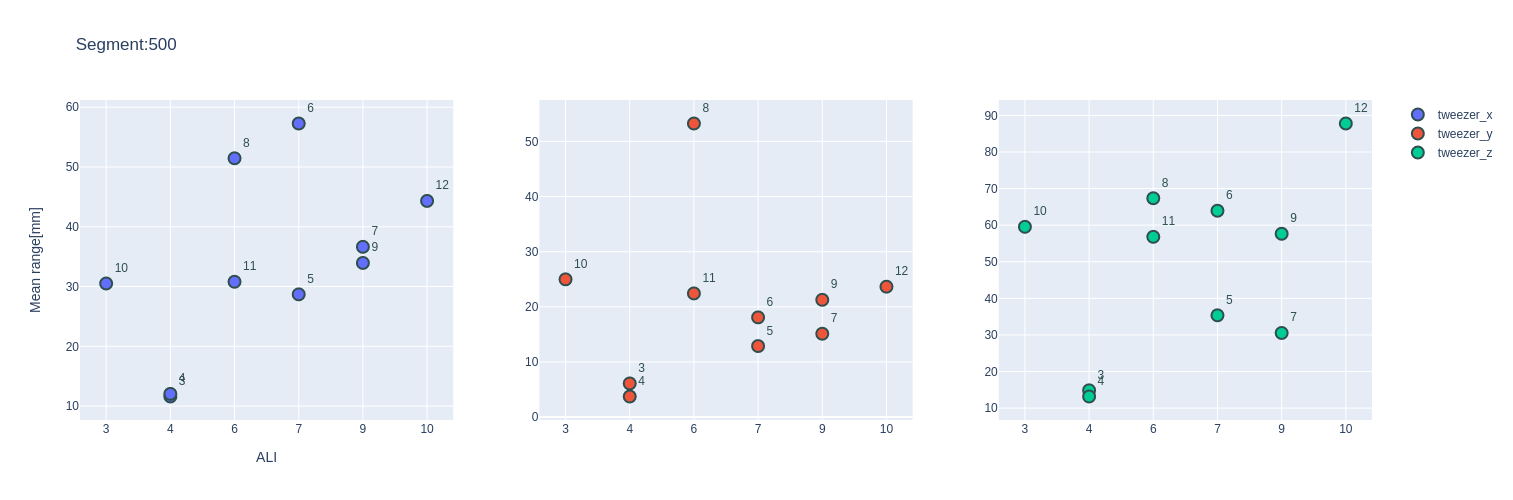

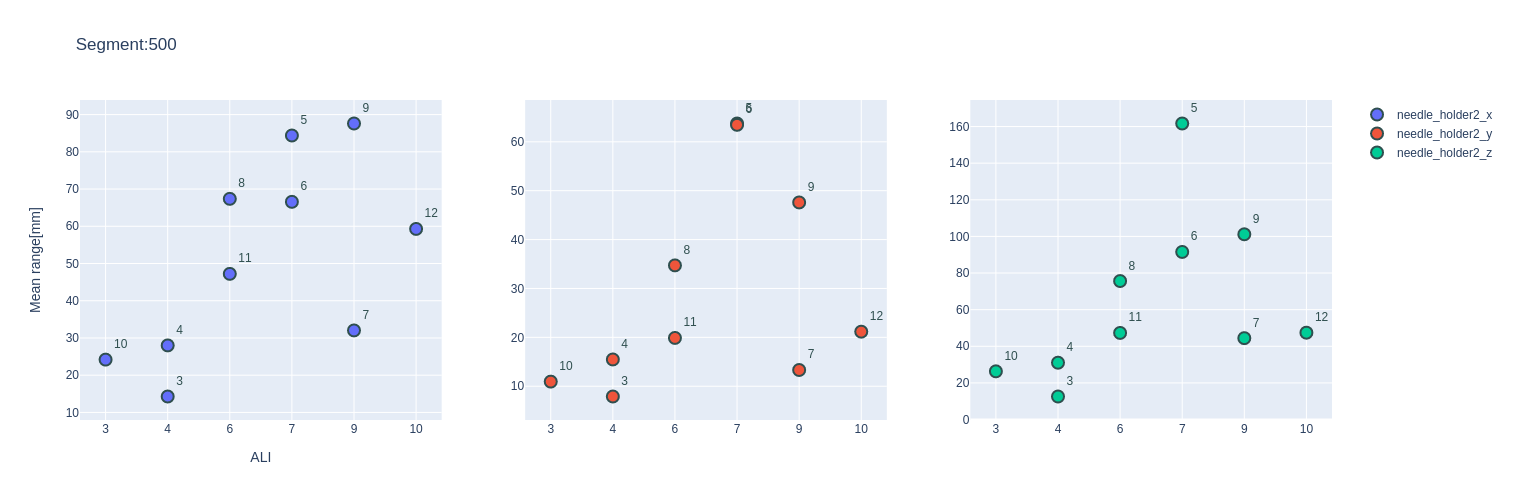

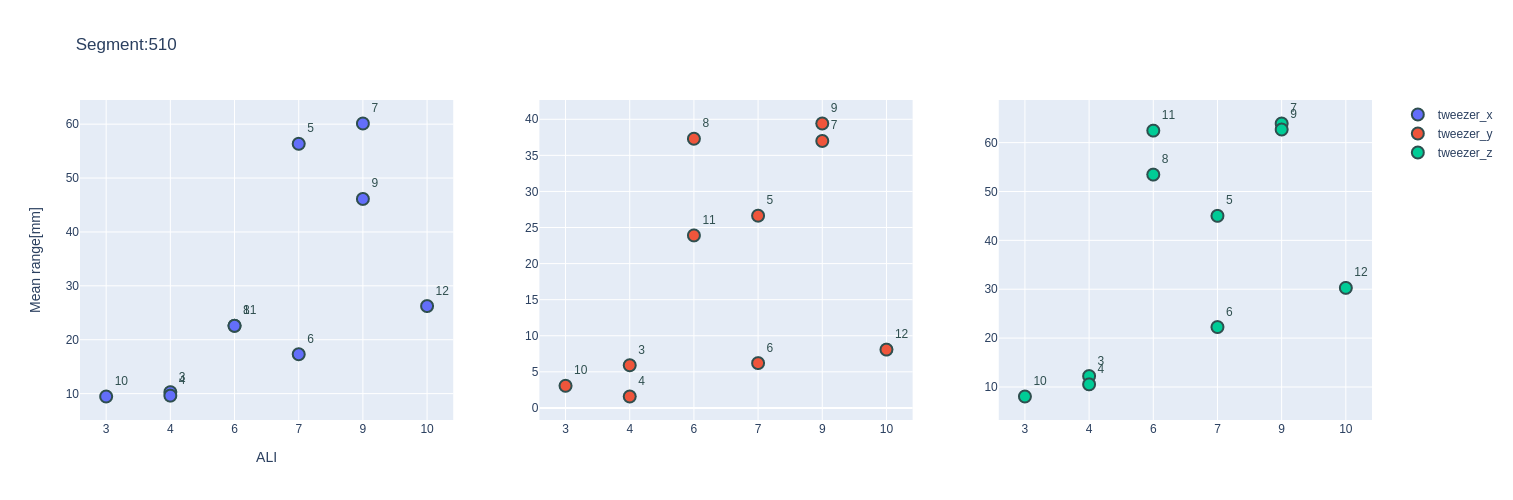

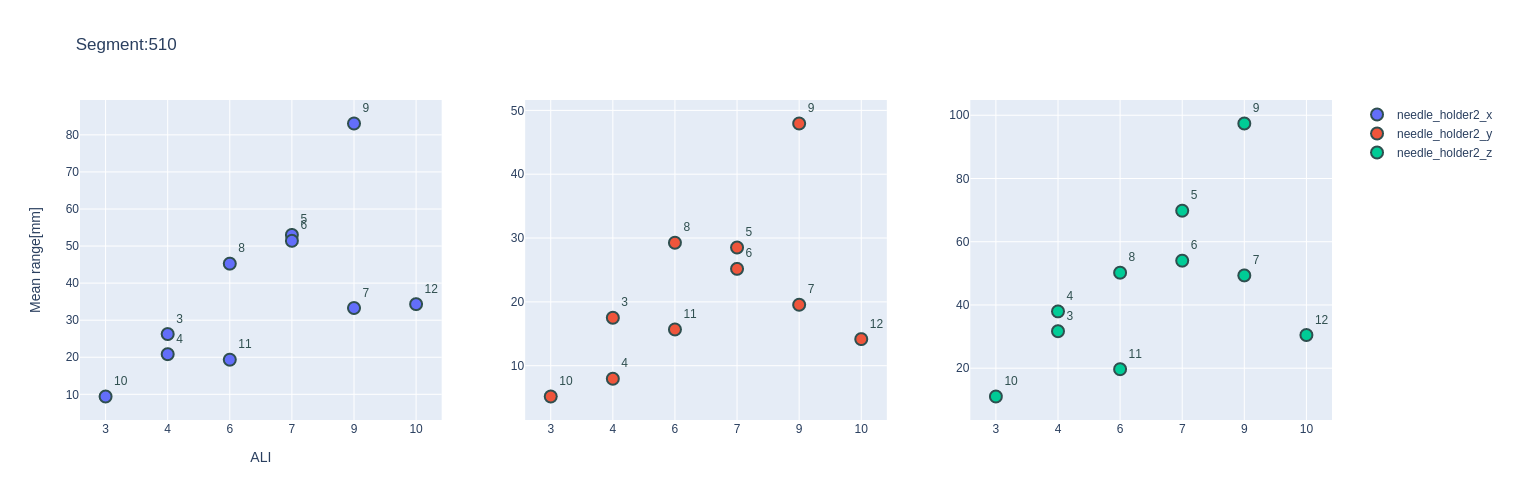

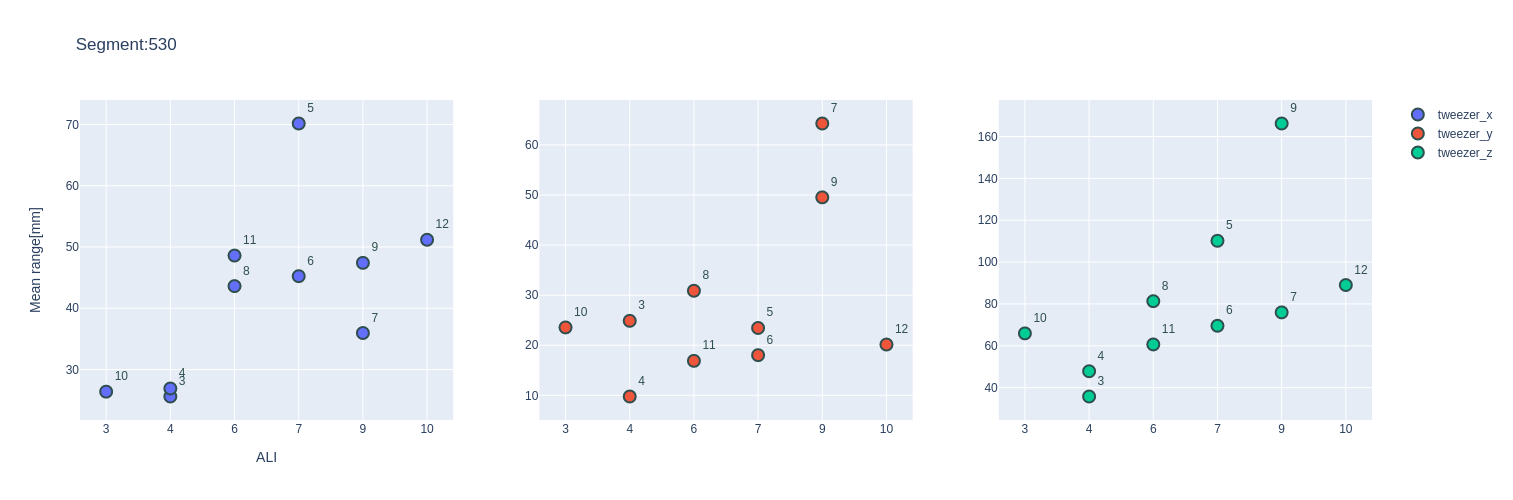

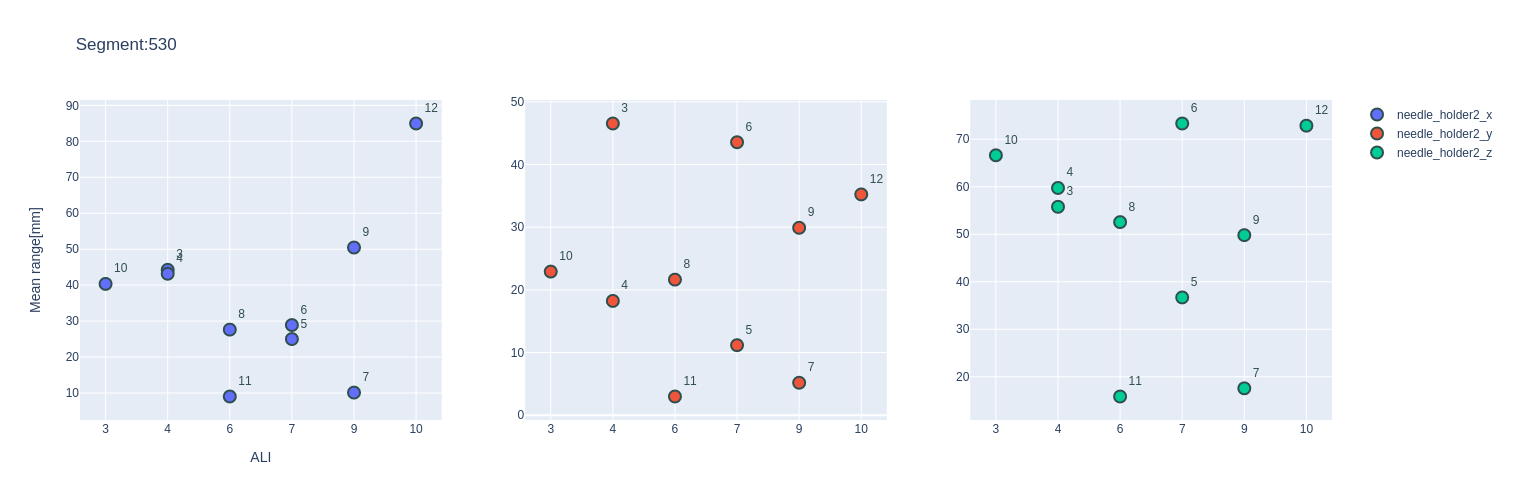

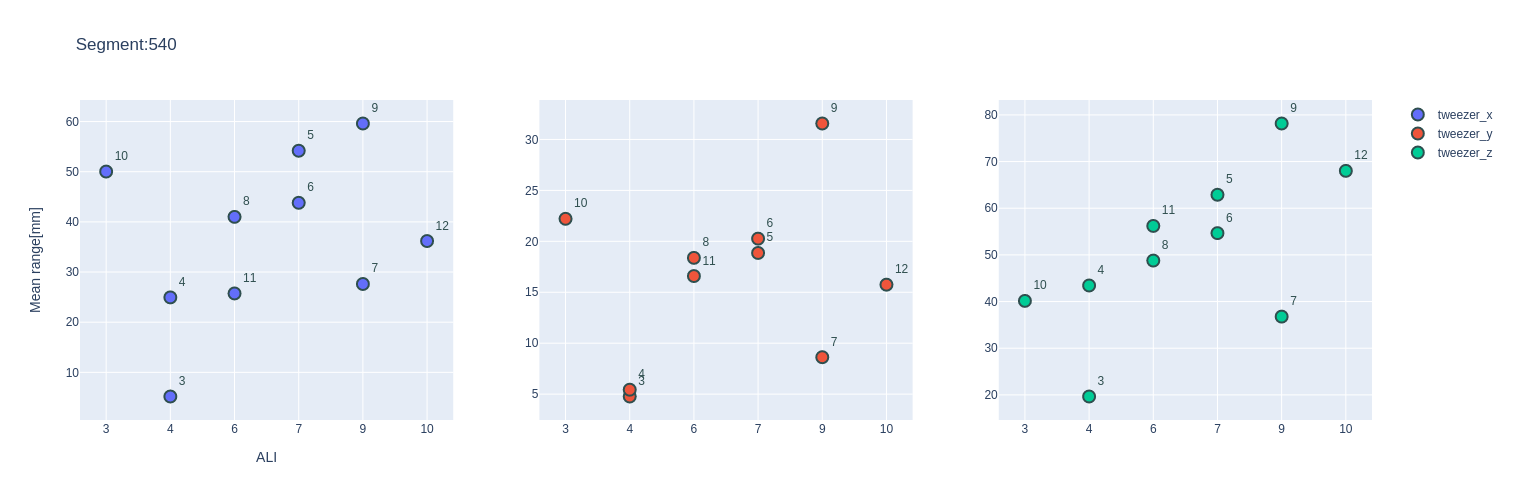

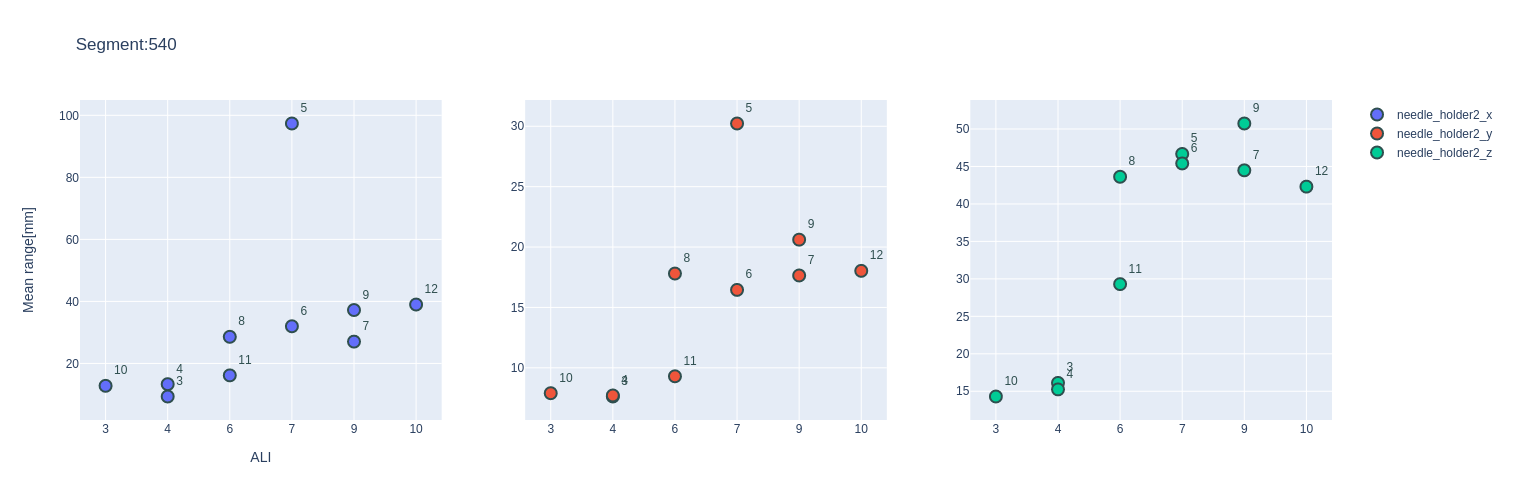

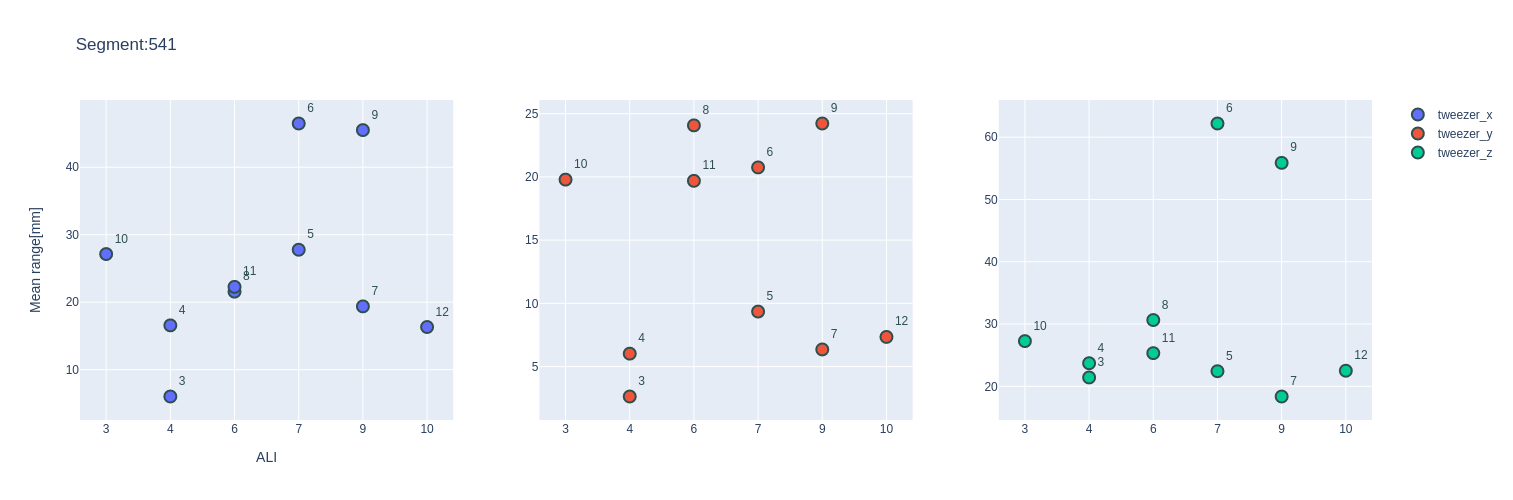

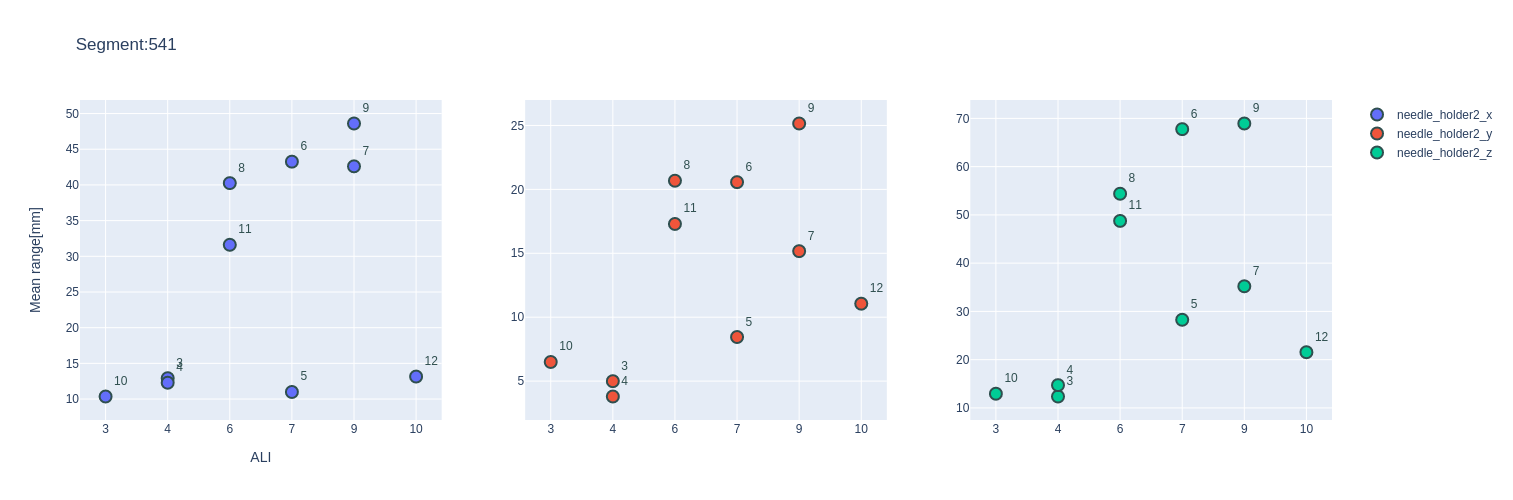

In [145]:
from tabulate import tabulate

range_travel = {}
mean_run_range_travel = {}
for subject in subject_list_optitrack:   
    range_travel[subject] = {}
    mean_run_range_travel[subject] = {}
    for segment in segment_list_optitrack:
        range_travel[subject][segment] = {}
        mean_run_range_travel[subject][segment] = {}
        for run in run_list[subject]:
        
            range_travel[subject][segment][run] = {}
            
            for tool in tools_position:
                range_travel[subject][segment][run][tool] = []
                
                mean_run_range_travel[subject][segment][tool] = []
                
                
data = []
col_names = ['Subject', 'Segment', tools_position[0], tools_position[1], tools_position[2],  tools_position[3],  tools_position[4],  tools_position[5]]
for subject in subject_list_optitrack: 
    for segment in segment_list_optitrack:
        for tool in tools_position:
            for run in run_list[subject]:
            
                range_travel[subject][segment][run][tool] = max(optitrack_non_zero[subject][segment][run][tool]) - min(optitrack_non_zero[subject][segment][run][tool])
                mean_run_range_travel[subject][segment][tool].append(range_travel[subject][segment][run][tool])
                
            mean_run_range_travel[subject][segment][tool] = np.mean( mean_run_range_travel[subject][segment][tool])  
        
        data.append([subject, segment, mean_run_range_travel[subject][segment][tools_position[0]]*1000,
                     mean_run_range_travel[subject][segment][tools_position[1]]*1000, 
                     mean_run_range_travel[subject][segment][tools_position[2]]*1000,
                    mean_run_range_travel[subject][segment][tools_position[3]]*1000,
                    mean_run_range_travel[subject][segment][tools_position[4]]*1000,
                    mean_run_range_travel[subject][segment][tools_position[5]]*1000]
                   )
                 
            
#print(tabulate(data, headers=col_names, tablefmt="grid"))

subject_order = ['10','3','4','8','11','5','6','7','9','12']
ALI_score = ['3','4','4','6','6','7','7','9','9','10']

for segment in segment_list_optitrack:
    y1 = {}
    for i,tool in enumerate(tools_position):
        #eb1 = []
        #x = []
        y1[i] = []
        #y2 = []
        #e1 = []
        #e2 = []
        for subject in subject_order:
            

            y1[i].append(mean_run_range_travel[subject][segment][tools_position[i]]*1000)
          
    

        x= ALI_score


    fig  = go.Figure()
    fig = make_subplots(rows=1, cols=3) 

    fig.add_trace(go.Scatter(y=y1[0], x=x, 
            text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name=tools_position[0]),1,1)
    fig.add_trace(go.Scatter(y=y1[1], x=x,
            text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name=tools_position[1]),1,2)
    fig.add_trace(go.Scatter(y=y1[2], x=x,
            text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name=tools_position[2]),1,3)


    fig.update_layout(title='Segment:' + str(segment) ,
               xaxis_title='ALI',
               yaxis_title='Mean range[mm]',
               width=1500,
               height=500,
                         )
    fig.update_traces(
        marker_size=12,
        marker_line=dict(width=2, color='#2F4F4F'),
        selector=dict(mode='markers+text'))
    

    #fig.update_yaxes(range=[0, 0.5])


    fig.show()
    if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'optitrack_hand_travel' )):
        os.makedirs(join(path_to_data_folder, 'PLOTS', 'optitrack_hand_travel'))
    fig.write_image(join('..', 'data_exp',  'PLOTS','optitrack_hand_travel', 'segment' + segment  +'tweezer.png'))
    
    
    fig  = go.Figure()
    fig = make_subplots(rows=1, cols=3) 

    fig.add_trace(go.Scatter(y=y1[3], x=x, text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name=tools_position[3]),1,1)
    fig.add_trace(go.Scatter(y=y1[4], x=x, text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name=tools_position[4]),1,2)
    fig.add_trace(go.Scatter(y=y1[5], x=x,text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name=tools_position[5]),1,3)
    fig.update_traces(
        marker_size=12,
        marker_line=dict(width=2, color='#2F4F4F'),
        selector=dict(mode='markers+text'))


    fig.update_layout(title=' Segment:' + str(segment) ,
               xaxis_title='ALI',
               yaxis_title='Mean range[mm]',
               width=1500,
               height=500,
                         )
    if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'optitrack_hand_travel' )):
        os.makedirs(join(path_to_data_folder, 'PLOTS', 'optitrack_hand_travel'))
    fig.write_image(join('..', 'data_exp',  'PLOTS','optitrack_hand_travel', 'segment' + segment  +'holder.png'))
    fig.show()

In [ ]:
print(data)
print(subject)

## compute speed and jerk

In [187]:

diff_optitrack = {}
diff_optitrack_time= {}
acc_optitrack = {}
acc_optitrack_time= {}
for subject in subject_list_optitrack:   
    diff_optitrack[subject]={}
    diff_optitrack_time[subject] ={}
    acc_optitrack[subject] ={}
    acc_optitrack_time[subject]= {}
    for segment in segment_list:
        diff_optitrack[subject][segment] = {}
        diff_optitrack_time[subject][segment]={}
        acc_optitrack[subject][segment]={}
        acc_optitrack_time[subject][segment]= {}
        for run in run_list[subject]:
            diff_optitrack[subject][segment][run]={}
            diff_optitrack_time[subject][segment][run]={}
            acc_optitrack[subject][segment][run]= {}
            acc_optitrack_time[subject][segment][run]={}
            for tool in tools:
                diff_optitrack[subject][segment][run][tool] = []
                diff_optitrack_time[subject][segment][run][tool] = []
                acc_optitrack[subject][segment][run][tool] = []
                acc_optitrack_time[subject][segment][run][tool] = []


for subject in subject_list_optitrack:   
    for run in run_list[subject]:
        for segment in segment_list:
            for tool in tools:
                data_current = np.array(optitrack_non_zero[subject][segment][run][tool] )
                time_current = np.array(optitrack_non_zero_time[subject][segment][run][tool] )
                #Newton diff method
                #diff_optitrack[subject][segment][run][tool] = (data_current[1:] - data_current[0:-1])/(time_current[1:] - time_current[0:-1])
                diff_optitrack[subject][segment][run][tool] = np.diff(data_current)/np.diff(time_current)
                diff_optitrack_time[subject][segment][run][tool] = ((time_current[1:]) + (time_current[0:-1]))/2
                
                
                acc_optitrack[subject][segment][run][tool] = np.diff(diff_optitrack[subject][segment][run][tool])/np.diff(diff_optitrack_time[subject][segment][run][tool])
                #acc_optitrack[subject][segment][run][tool] = (data_current[1:] - data_current[0:-1])/(time_current[1:] - time_current[0:-1])
                acc_optitrack_time[subject][segment][run][tool] = ( np.array(diff_optitrack_time[subject][segment][run][tool][1:]) +  np.array(diff_optitrack_time[subject][segment][run][tool][0:-1]))/2
                                                                     
                                                                     
                                                                     
for subject in subject_list_optitrack:   
    for run in run_list[subject]:
        for segment in segment_list:
            
            fig = go.Figure()
            fig = make_subplots(rows=1, cols=2) 
            for tool in tools_position[0:3]:  
                time_current =  diff_optitrack_time[subject][segment][run][tool]
                data_current = diff_optitrack[subject][segment][run][tool]
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][run][sensor][segment]['rel_time'][0],
                    mode='lines', name=tool),1,1)
                
            for tool in tools_position[3:]:  
                time_current =  diff_optitrack_time[subject][segment][run][tool]
                data_current = diff_optitrack[subject][segment][run][tool]
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][run][sensor][segment]['rel_time'][0],
                    mode='lines', name=tool),1,2)
                
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                xaxis_title='Time',
                yaxis_title='Speed [m/s]',
                width=1000,
                height=500)
            #fig.show()
                       
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' ))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack', 'optitrack_speed_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))


for subject in subject_list_optitrack:   
    for run in run_list[subject]:
        for segment in segment_list:
            
            fig = go.Figure()
            fig = make_subplots(rows=1, cols=2) 
            for tool in tools_position[0:3]:  
                time_current = acc_optitrack_time[subject][segment][run][tool]
                data_current = acc_optitrack[subject][segment][run][tool] 
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][run][sensor][segment]['rel_time'][0],
                    mode='lines', name=tool),1,1)
                
            for tool in tools_position[3:]:  
                time_current =  acc_optitrack_time[subject][segment][run][tool]
                data_current = acc_optitrack[subject][segment][run][tool] 
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][run][sensor][segment]['rel_time'][0],
                    mode='lines', name=tool),1,2)
                
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                xaxis_title='Time',
                yaxis_title='Acceleration [m/s2]',
                width=1000,
                height=500)
            #fig.show()
                       
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' ))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack', 'optitrack_acc_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))


In [176]:
data_current = np.array(optitrack_non_zero[subject][segment][run][tool] )
time_current = np.array(optitrack_non_zero_time[subject][segment][run][tool] )
#Newton diff method
diff_optitrack[subject][segment][run][tool] = (data_current[1:] - data_current[0:-1])/(time_current[1:] - time_current[0:-1])
#diff_optitrack[subject][segment][run][tool] = np.diff(data_current)/np.diff(time_current)
diff_optitrack_time[subject][segment][run][tool] = ((time_current[1:]) + (time_current[0:-1]))/2
print(diff_optitrack[subject][segment][run][tool] )

[ 0.00048101 -0.00789911 -0.00854552 ... -0.03686786 -0.05402386
 -0.12536108]


In [174]:
 print(diff_optitrack_time[subject][segment][run][tool])

[6346.25       6346.26666667 6346.27916667 ... 6392.59583333 6392.6125
 6392.6375    ]


In [186]:
subject_list_optitrack = ['3','4','5','6','7','8','9','10','11','12']
